In [1]:
import tensorflow as tf # Make sure that python interpreter is 3.9.13 Global env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Loading Data

In [2]:
ptb = pd.read_csv('../data/ptbxl_database.csv')

def load_raw_data(df, sampling_rate, path):
    if(sampling_rate == 100):
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate=100
# load and convert annotation data
Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


# Load raw signal data
X = load_raw_data(Y, 100, '../data/')

In [3]:
X = X[(Y.validated_by_human == True)]
Y = Y[(Y.validated_by_human == True)]



## Data Augmentation

### Normalization

In [4]:
def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

### Baseline Drift Augmentation

In [5]:
import random
# Defining constant BL drift
bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

### DA Applyer

In [6]:
def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]


func_dict = [{'func': normalize, 'params': [None]}, 
             {'func': baseline_drift, 'params': [0,0.1]}] # 0.075 works nicely

X_final = da_apply(X, func_dict)

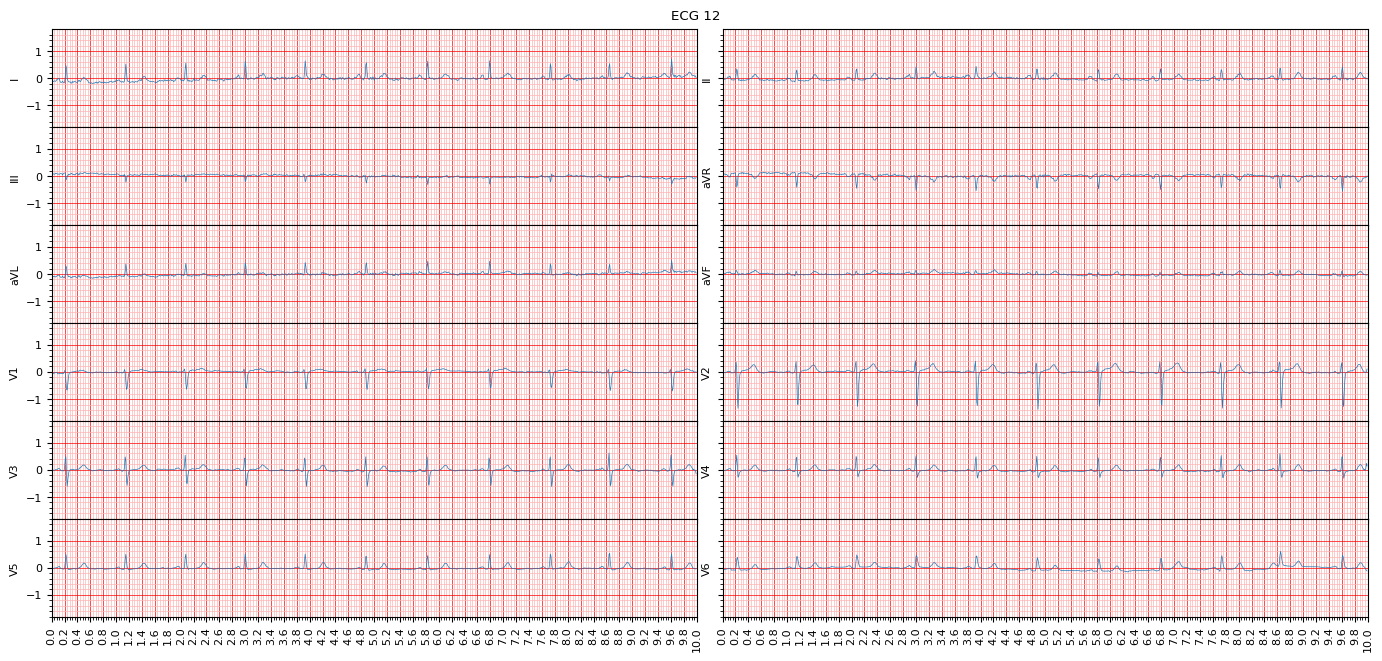

In [7]:
ecg_plot.plot_12(tf.transpose(X, (0,2,1))[0], sample_rate=100)


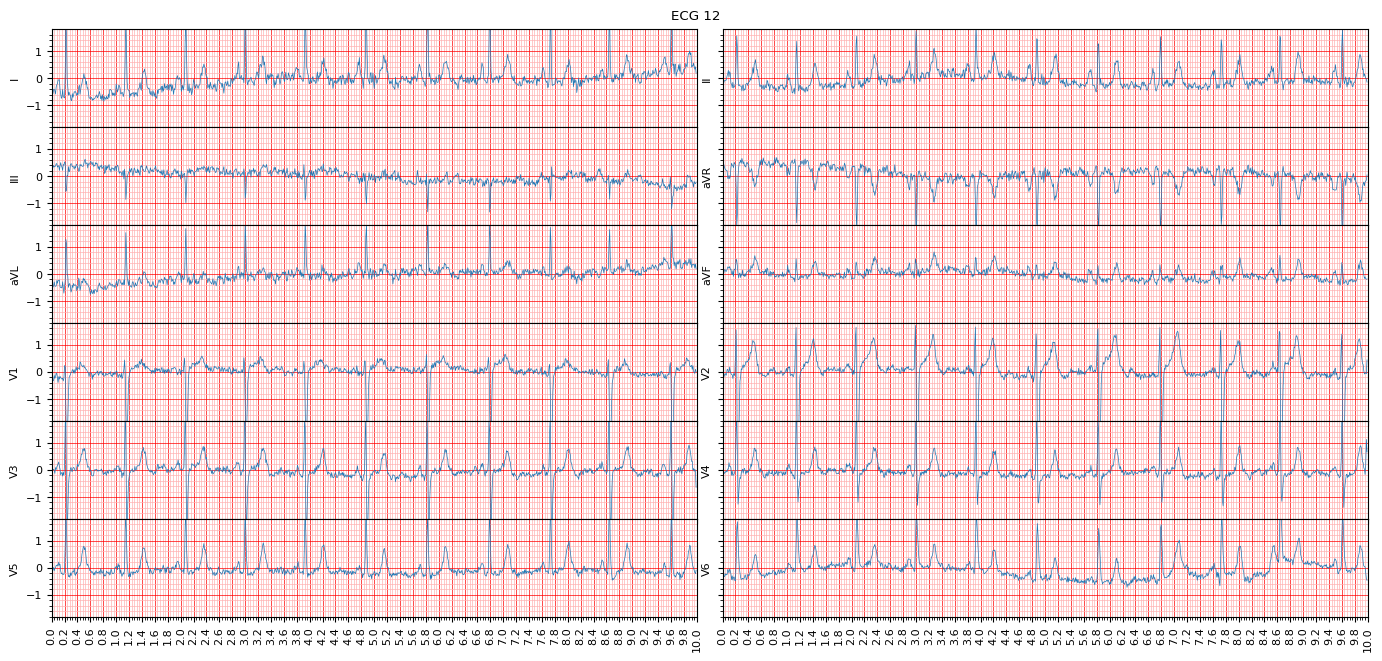

In [8]:
with tf.device('/device:CPU:0'):
    ecg_plot.plot_12(tf.transpose(X_final, (0,2,1))[0], sample_rate=100)

### Splitting data into Train, Validation, Testing

In [9]:

# Split data into train and test
test_fold =10
val_fold = 9

def tvt_split(X, Y, val_fold, test_fold, shape = False):
    X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
    y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].sex #Watch out for column

    X_val = X[Y.strat_fold == val_fold]
    y_val = Y[Y.strat_fold == val_fold].sex

    X_test = X[(Y.strat_fold == test_fold)]
    y_test = Y[Y.strat_fold == test_fold].sex

    y_train = pd.get_dummies(y_train)
    y_val = pd.get_dummies(y_val)
    y_test = pd.get_dummies(y_test)

    y_train = y_train.idxmax(axis = 1).to_numpy()
    y_val = y_val.idxmax(axis = 1).to_numpy()
    y_test = y_test.idxmax(axis = 1).to_numpy()

    if(shape == True):
        print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((11675, 1000, 12), (11675,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


In [10]:
# del(X_final)
# del(X_final, X_train, y_train, X_val, y_val, X_test, y_test)

## Models

### Model 1

In [11]:
# Creating the model
ecg_sex_model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 7, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 48, kernel_size = 6, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=3, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dropout(0.2, seed = 13),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model
ecg_sex_model_1.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                      metrics = ['accuracy'])


# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)



# Fitting the model
history_4 = ecg_sex_model_1.fit(X_train, y_train, epochs = 15, validation_data = (X_val, y_val))

Epoch 1/15
365/365 [==============================] - 8s 15ms/step - loss: 0.5685 - accuracy: 0.7245 - val_loss: 0.5029 - val_accuracy: 0.7586
Epoch 2/15
365/365 [==============================] - 5s 14ms/step - loss: 0.4591 - accuracy: 0.7866 - val_loss: 0.5190 - val_accuracy: 0.7723
Epoch 3/15
365/365 [==============================] - 5s 14ms/step - loss: 0.4375 - accuracy: 0.7955 - val_loss: 0.5770 - val_accuracy: 0.7320
Epoch 4/15
365/365 [==============================] - 5s 14ms/step - loss: 0.4105 - accuracy: 0.8106 - val_loss: 0.4310 - val_accuracy: 0.7902
Epoch 5/15
365/365 [==============================] - 5s 14ms/step - loss: 0.4045 - accuracy: 0.8141 - val_loss: 0.4938 - val_accuracy: 0.7728
Epoch 6/15
365/365 [==============================] - 5s 14ms/step - loss: 0.3825 - accuracy: 0.8270 - val_loss: 0.4332 - val_accuracy: 0.7929
Epoch 7/15
365/365 [==============================] - 5s 14ms/step - loss: 0.3685 - accuracy: 0.8369 - val_loss: 0.4393 - val_accuracy: 0.7966

### Model 2

In [12]:
tf.debugging.disable_traceback_filtering
# Random Seed
tf.random.set_seed(13)

# Creating the model
ecg_sex_model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 7, strides = 3, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 96, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 4, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 160, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),
    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model
ecg_sex_model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0009),
                      metrics = ['accuracy'])


# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model
history_6 = ecg_sex_model_2.fit(X_train, y_train, epochs = 15, validation_data = (X_val, y_val))

Epoch 1/15
365/365 [==============================] - 8s 17ms/step - loss: 4.9150 - accuracy: 0.7370 - val_loss: 1.4231 - val_accuracy: 0.7503
Epoch 2/15
365/365 [==============================] - 6s 16ms/step - loss: 1.2919 - accuracy: 0.7802 - val_loss: 1.2669 - val_accuracy: 0.7769
Epoch 3/15
365/365 [==============================] - 6s 17ms/step - loss: 1.1164 - accuracy: 0.7960 - val_loss: 1.2019 - val_accuracy: 0.7572
Epoch 4/15
365/365 [==============================] - 6s 17ms/step - loss: 1.0606 - accuracy: 0.8027 - val_loss: 1.0555 - val_accuracy: 0.8053
Epoch 5/15
365/365 [==============================] - 6s 17ms/step - loss: 1.0119 - accuracy: 0.8133 - val_loss: 0.9889 - val_accuracy: 0.7856
Epoch 6/15
365/365 [==============================] - 10s 26ms/step - loss: 1.0059 - accuracy: 0.8176 - val_loss: 1.0018 - val_accuracy: 0.7939
Epoch 7/15
365/365 [==============================] - 6s 17ms/step - loss: 0.9785 - accuracy: 0.8196 - val_loss: 0.9814 - val_accuracy: 0.784

### Model 3

In [13]:

# Creating the model
ecg_sex_model_7 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'sigmoid')
])


# Compiling the model
ecg_sex_model_7.compile(loss = tf.keras.losses.binary_crossentropy,
                      optimizer = tf.keras.optimizers.Adam(learning_rate= .001),
                      metrics = ['accuracy'])


# Learning rate scheduler
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 5)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))



# Fitting the model
history_7 = ecg_sex_model_7.fit(X_train, y_train, epochs = 20, validation_data = (X_val, y_val))

Epoch 1/20
365/365 [==============================] - 18s 41ms/step - loss: 0.5994 - accuracy: 0.7036 - val_loss: 0.5743 - val_accuracy: 0.7247
Epoch 2/20
365/365 [==============================] - 14s 39ms/step - loss: 0.4809 - accuracy: 0.7734 - val_loss: 0.4911 - val_accuracy: 0.7769
Epoch 3/20
365/365 [==============================] - 21s 58ms/step - loss: 0.4445 - accuracy: 0.7954 - val_loss: 0.4435 - val_accuracy: 0.7966
Epoch 4/20
365/365 [==============================] - 31s 84ms/step - loss: 0.4197 - accuracy: 0.8076 - val_loss: 0.4573 - val_accuracy: 0.8044
Epoch 5/20
365/365 [==============================] - 14s 39ms/step - loss: 0.3944 - accuracy: 0.8207 - val_loss: 0.4972 - val_accuracy: 0.7893
Epoch 6/20
365/365 [==============================] - 14s 39ms/step - loss: 0.3812 - accuracy: 0.8290 - val_loss: 0.5011 - val_accuracy: 0.7732
Epoch 7/20
365/365 [==============================] - 14s 39ms/step - loss: 0.3610 - accuracy: 0.8389 - val_loss: 0.4799 - val_accuracy:

## Performance

### Visualizing Performance

In [14]:
import itertools
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 
import itertools

figsize = (10, 10)

def make_confusion_matrix(X_test, y_test, classes, model, figsize=(18,18), text_size = 15):
    # Create the confusion matrix
    y_prob = model.predict(X_test)
    y_pred =np.squeeze(np.where(y_prob >= 0.5, 1, 0))
    cm = confusion_matrix(y_test, tf.round(y_pred))
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]

    # Let's prettify it
    fig, ax = plt.subplots(figsize=figsize)
    # Create a matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
    fig.colorbar(cax)

    # Create classes
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title=(str(model.name) + " for Confusion Matrix"),
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=10)

69/69 [==============================] - 1s 5ms/step


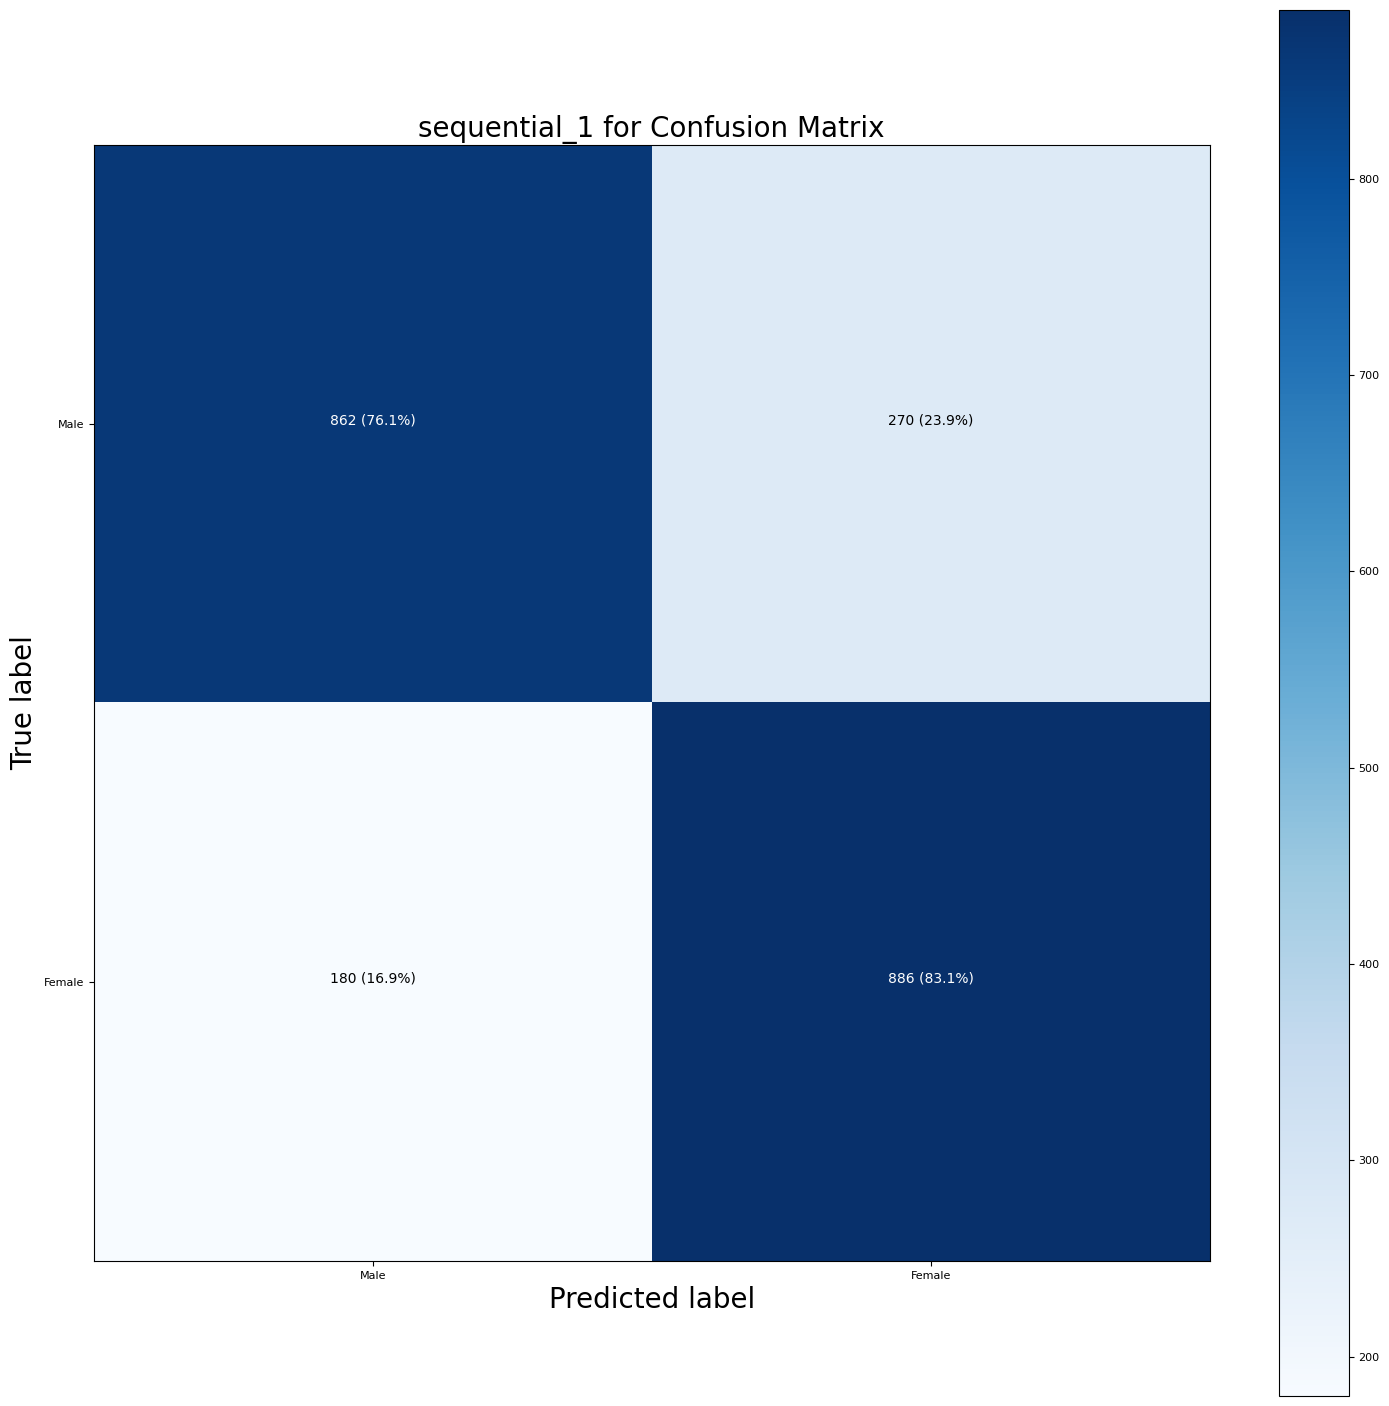

In [15]:
class_name = ['Male', 'Female']
make_confusion_matrix(X_test, y_test, model = ecg_sex_model_2, classes = class_name)

